In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import chi2_contingency, pearsonr
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score


pd.set_option('display.max_columns', None)



In [2]:
df = pd.read_csv('flight_weather_merged.csv')

/tmp/ipykernel_13478/3965383140.py:1: DtypeWarning: Columns (30,54) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('flight_weather_merged.csv')


In [3]:
# Sort by scheduledoffblocktime
df['scheduledoffblocktime'] = pd.to_datetime(df['scheduledoffblocktime'])
df = df.sort_values('scheduledoffblocktime')

cutoff_idx = int(len(df) * 0.8)
flight_data_train = df.iloc[:cutoff_idx]
flight_data_test = df.iloc[cutoff_idx:]


# # Sort by scheduledoffblocktime
# df['scheduledoffblocktime'] = pd.to_datetime(df['scheduledoffblocktime'])
# df = df.sort_values('scheduledoffblocktime')

# # Get the date of the last 10% of data
# cutoff_date = df['scheduledoffblocktime'].iloc[int(len(df) * 0.9)].date()

# # Split ensuring full days are kept together
# flight_data_train = df[df['scheduledoffblocktime'].dt.date < cutoff_date]
# flight_data_test = df[df['scheduledoffblocktime'].dt.date >= cutoff_date]

flight_data_train.info(verbose=True)


<class 'pandas.core.frame.DataFrame'>
Index: 152640 entries, 0 to 152639
Data columns (total 65 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   aodbuniquefield                152640 non-null  int64         
 1   flightstatus                   152640 non-null  object        
 2   aircraftregistration           152551 non-null  object        
 3   flightnumber                   152640 non-null  object        
 4   traffictypecode                152640 non-null  object        
 5   arrivalordeparture             152640 non-null  object        
 6   lastchanged                    152640 non-null  object        
 7   airlinecode_iata               152640 non-null  object        
 8   airlinecode_icao               152640 non-null  object        
 9   jointflightnumber              13380 non-null   object        
 10  destination_iata               152640 non-null  object        
 11  desti

In [4]:
flight_data_train.head()

,aodbuniquefield,flightstatus,aircraftregistration,flightnumber,traffictypecode,arrivalordeparture,lastchanged,airlinecode_iata,airlinecode_icao,jointflightnumber,destination_iata,destination_icao,via_iata,via_icao,aircraft_iata,aircraft_icao,flightstatuscode,publicscheduleddatetime,scheduledoffblocktime,estimatedoffblocktime,actualtakeofftime,actualoffblocktime,aircraftparkingposition,publicgatenumber,checkinallocationfrom,checkinallocationto,airlinename,vianame,destinationname,traffictype,aircraftterminal,airlinenamea,destinationnamea,vianamea,flightstatustexta,delaytimedelta,finalflightstatus,delay_in_secs,scheduledoffblocktime_rounded,station,valid,lon,lat,elevation,tmpf,dwpf,relh,drct,sknt,p01i,alti,vsby,gust,skyc1,skyc2,skyc3,skyc4,skyl1,skyl2,skyl3,skyl4,wxcodes,feel,metar,time_dubai
0,355872742,Departed,9NALZ,RA 230,PS,D,2020-03-08 05:24:05,RA,RNA,NaN,KTM,VNKT,NaN,NaN,332,A332,DEP,2020-03-08 04:25:00,2020-03-08 04:25:00,2020-03-08 04:25:00,NaN,2020-03-08 04:24:08,E02,F8,N241,N245,Royal Nepal Airlines,NaN,Kathmandu,Passenger Scheduled,2,الخطوط الجوية الملكية النيبالية,كتمندو,NaN,غادرت,0 days 00:00:00,On-Time,0.0,2020-03-08 04:00:00,OMDB,2020-03-08 00:00,55.3656,25.2539,5.0,69.8,62.6,77.90,90.0,5.0,0.0,29.88,6.21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,69.8,OMDB 080000Z 09005KT 040V110 CAVOK 21/17 Q1012...,2020-03-08 04:00:00
1,354813921,Departed,ETAPX,ET 601,PS,D,2020-03-08 06:59:26,ET,ETH,NaN,ADD,HAAB,NaN,NaN,77W,B77W,DEP,2020-03-08 04:25:00,2020-03-08 04:25:00,2020-03-08 04:25:00,NaN,2020-03-08 04:37:26,C52,D6,422,429,Ethiopian Airlines,NaN,Addis Ababa,Passenger Scheduled,1,الخطوط الجوية الاثيوبية,أديس أبابا,NaN,غادرت,0 days 00:12:26,On-Time,746.0,2020-03-08 04:00:00,OMDB,2020-03-08 00:00,55.3656,25.2539,5.0,69.8,62.6,77.90,90.0,5.0,0.0,29.88,6.21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,69.8,OMDB 080000Z 09005KT 040V110 CAVOK 21/17 Q1012...,2020-03-08 04:00:00
2,353476721,Departed,VTIGW,6E 1769,PS,D,2020-03-08 04:59:43,6E,IGO,NaN,BOM,VABB,NaN,NaN,320,A320,DEP,2020-03-08 04:30:00,2020-03-08 04:30:00,2020-03-08 04:30:00,NaN,2020-03-08 04:20:47,C53R,D7,342A,342A,Indigo,NaN,Mumbai (Bombay),Passenger Scheduled,1,انديقو,مومباي - بومبي,NaN,غادرت,0 days 00:00:00,On-Time,0.0,2020-03-08 04:00:00,OMDB,2020-03-08 00:00,55.3656,25.2539,5.0,69.8,62.6,77.90,90.0,5.0,0.0,29.88,6.21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,69.8,OMDB 080000Z 09005KT 040V110 CAVOK 21/17 Q1012...,2020-03-08 04:00:00
3,354511674,Departed,A6EGS,EK 658,PS,D,2020-03-08 08:34:27,EK,UAE,NaN,MLE,VRMM,NaN,NaN,77W,B77W,DEP,2020-03-08 04:35:00,2020-03-08 04:35:00,2020-03-08 04:35:00,NaN,2020-03-08 04:31:05,B08,C14,NaN,NaN,Emirates,NaN,Male,Passenger Scheduled,3,طيران الإمارات,مـالى,NaN,غادرت,0 days 00:00:00,On-Time,0.0,2020-03-08 05:00:00,OMDB,2020-03-08 01:00,55.3656,25.2539,5.0,68.0,60.8,77.75,110.0,6.0,0.0,29.88,5.59,NaN,NSC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,68.0,OMDB 080100Z 11006KT 060V120 9000 NSC 20/16 Q1...,2020-03-08 05:00:00
4,354229669,Departed,A6ENG,EK 356,PS,D,2020-03-08 12:28:11,EK,UAE,NaN,CGK,WIII,NaN,NaN,77W,B77W,DEP,2020-03-08 04:35:00,2020-03-08 04:35:00,2020-03-08 04:35:00,NaN,2020-03-08 04:34:20,D01,A8,NaN,NaN,Emirates,NaN,Jakarta/Cengekareng,Passenger Scheduled,3,طيران الإمارات,جاكارتا,NaN,غادرت,0 days 00:00:00,On-Time,0.0,2020-03-08 05:00:00,OMDB,2020-03-08 01:00,55.3656,25.2539,5.0,68.0,60.8,77.75,110.0,6.0,0.0,29.88,5.59,NaN,NSC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,68.0,OMDB 080100Z 11006KT 060V120 9000 NSC 20/16 Q1...,2020-03-08 05:00:00


In [5]:
columns_to_drop = [
    "aodbuniquefield",
    "flightstatus",  # not needed as it does not contain the delayed status
    "flightstatuscode",
    "aircraftregistration",
    "actualtakeofftime",
    "metar",
    "time_dubai",
    "checkinallocationfrom",
    "checkinallocationto",
    "actualoffblocktime",  # not required as we have the targets already derived using this
    "publicscheduleddatetime",  # Mostly same as the scheduledoffblocktime
    "estimatedoffblocktime",  # data not available
    "delaytimedelta",  # This is coverted to finalflightstatus for classification and to finalflightstatus for regression
    "wxcodes",
    "airlinenamea",
    "destinationnamea",
    "vianamea",
    "flightstatustexta",
    "arrivalordeparture",
    "lastchanged",
    "scheduledoffblocktime_rounded",
    "station",
    "valid",
    "lon",
    "lat",
    "elevation",
    # 'aircraftterminal'
]

In [6]:
flight_data_train.dtypes

aodbuniquefield           int64
flightstatus             object
aircraftregistration     object
flightnumber             object
traffictypecode          object
                         ...   
skyl4                   float64
wxcodes                  object
feel                    float64
metar                    object
time_dubai               object
Length: 65, dtype: object

In [7]:
def chi_2(df, x, y):
    # Create a contingency table
    contingency_table = pd.crosstab(df[x], df[y])

    # Perform the Chi-Square test
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    print(f"Chi-Square Statistic for {x} and {y}: {chi2}, p-value: {p}, dof:{dof}")

In [8]:
def cramers_v(df, x, y):
    # Create a contingency table
    contingency_table = pd.crosstab(df[x], df[y])
    
    # Perform the Chi-Square test
    chi2, p, _, _ = chi2_contingency(contingency_table)
    
    # Calculate Cramér's V
    n = contingency_table.sum().sum()
    min_dim = min(contingency_table.shape) - 1
    cor = np.sqrt(chi2 / (n * min_dim))
    print(f"Cramer's V  for {x} and {y}: {cor}, p-value: {p}")

Airline code and name

In [9]:
flight_data_train['airlinecode_iata'].nunique()

147

In [10]:
flight_data_train['airlinecode_icao'].nunique()

156

In [11]:
chi_2(flight_data_train, 'airlinecode_iata', 'airlinecode_icao')
cramers_v(flight_data_train, 'airlinecode_iata', 'airlinecode_icao')

Chi-Square Statistic for airlinecode_iata and airlinecode_icao: 22285440.0, p-value: 0.0, dof:22630
Cramer's V  for airlinecode_iata and airlinecode_icao: 1.0, p-value: 0.0


In [12]:
chi_2(flight_data_train, 'airlinecode_iata', 'airlinename')
cramers_v(flight_data_train, 'airlinecode_iata', 'airlinename')

Chi-Square Statistic for airlinecode_iata and airlinename: 22132800.0, p-value: 0.0, dof:22484
Cramer's V  for airlinecode_iata and airlinename: 0.9965694581570854, p-value: 0.0


The p-value is very less than 0.5 and ~0.0 which indicated high correlations so we can drop one of the columns
The Cramers V is also 1 or close to 1

In [13]:
columns_to_drop.append('airlinecode_icao')
columns_to_drop.append('airlinename')

Airpot code

In [14]:
chi_2(flight_data_train, 'destination_icao', 'destination_iata')
cramers_v(flight_data_train, 'destination_icao', 'destination_iata')

Chi-Square Statistic for destination_icao and destination_iata: 47165760.0, p-value: 0.0, dof:97343
Cramer's V  for destination_icao and destination_iata: 0.9967793797189012, p-value: 0.0


In [15]:
chi_2(flight_data_train, 'destinationname', 'destination_iata')
cramers_v(flight_data_train, 'destinationname', 'destination_iata')

Chi-Square Statistic for destinationname and destination_iata: 45454238.0, p-value: 0.0, dof:92092
Cramer's V  for destinationname and destination_iata: 0.9983263586596564, p-value: 0.0


In [16]:
chi_2(flight_data_train, 'destination_icao', 'destinationname')
cramers_v(flight_data_train, 'destination_icao', 'destinationname')

Chi-Square Statistic for destination_icao and destinationname: 45450735.99473051, p-value: 0.0, dof:93016
Cramer's V  for destination_icao and destinationname: 0.9933171410527091, p-value: 0.0


In [17]:
columns_to_drop.append('destination_icao')
columns_to_drop.append('destinationname')

Via codes and name

In [18]:
chi_2(flight_data_train, 'via_icao', 'via_iata')
cramers_v(flight_data_train, 'via_icao', 'via_iata')

chi_2(flight_data_train, 'vianame', 'via_iata')
cramers_v(flight_data_train, 'vianame', 'via_iata')

chi_2(flight_data_train, 'via_icao', 'vianame')
cramers_v(flight_data_train, 'via_icao', 'vianame')


chi_2(flight_data_train, 'via_iata', 'jointflightnumber')
cramers_v(flight_data_train, 'via_iata', 'jointflightnumber')

Chi-Square Statistic for via_icao and via_iata: 608833.0, p-value: 0.0, dof:10609
Cramer's V  for via_icao and via_iata: 1.0, p-value: 0.0
Chi-Square Statistic for vianame and via_iata: 559968.0, p-value: 0.0, dof:9312
Cramer's V  for vianame and via_iata: 1.0, p-value: 0.0
Chi-Square Statistic for via_icao and vianame: 559968.0, p-value: 0.0, dof:9312
Cramer's V  for via_icao and vianame: 1.0, p-value: 0.0
Chi-Square Statistic for via_iata and jointflightnumber: 17738.0, p-value: 0.0, dof:270
Cramer's V  for via_iata and jointflightnumber: 0.9660917830792959, p-value: 0.0


In [19]:
columns_to_drop.append('via_icao')
columns_to_drop.append('vianame')
columns_to_drop.append('jointflightnumber')

Flight and aircraft details

In [20]:
chi_2(flight_data_train, 'flightnumber', 'aircraft_iata')
cramers_v(flight_data_train, 'flightnumber', 'aircraft_iata')
chi_2(flight_data_train, 'aircraft_icao', 'aircraft_iata')
cramers_v(flight_data_train, 'aircraft_icao', 'aircraft_iata')
chi_2(flight_data_train, 'aircraft_icao', 'flightnumber')
cramers_v(flight_data_train, 'aircraft_icao', 'flightnumber')

Chi-Square Statistic for flightnumber and aircraft_iata: 4216825.404912903, p-value: 0.0, dof:117720
Cramer's V  for flightnumber and aircraft_iata: 0.6785517985671197, p-value: 0.0
Chi-Square Statistic for aircraft_icao and aircraft_iata: 7632000.0, p-value: 0.0, dof:3120
Cramer's V  for aircraft_icao and aircraft_iata: 0.9805806756909202, p-value: 0.0
Chi-Square Statistic for aircraft_icao and flightnumber: 3868193.8959490512, p-value: 0.0, dof:102024
Cramer's V  for aircraft_icao and flightnumber: 0.698101011291234, p-value: 0.0


One out of 'aircraft_icao', 'aircraft_iata' can be dropped

In [21]:
columns_to_drop.append('aircraft_icao')

flightnumber and destination_iata

In [22]:
chi_2(flight_data_train, 'flightnumber', 'destination_iata')
cramers_v(flight_data_train, 'flightnumber', 'destination_iata')
chi_2(flight_data_train, 'airlinecode_iata', 'destination_iata')
cramers_v(flight_data_train, 'airlinecode_iata', 'destination_iata')

Chi-Square Statistic for flightnumber and destination_iata: 43608823.06652782, p-value: 0.0, dof:610182
Cramer's V  for flightnumber and destination_iata: 0.9584573888595723, p-value: 0.0
Chi-Square Statistic for airlinecode_iata and destination_iata: 6490340.243631285, p-value: 0.0, dof:45406
Cramer's V  for airlinecode_iata and destination_iata: 0.539663599396242, p-value: 0.0


In [23]:
columns_to_drop.append('flightnumber')

publicgatenumber and aircraftterminal

In [24]:
chi_2(flight_data_train, 'publicgatenumber', 'aircraftparkingposition')
cramers_v(flight_data_train, 'publicgatenumber', 'aircraftparkingposition')

Chi-Square Statistic for publicgatenumber and aircraftparkingposition: 13336222.341236642, p-value: 0.0, dof:30551
Cramer's V  for publicgatenumber and aircraftparkingposition: 0.7994931247061621, p-value: 0.0


In [25]:
columns_to_drop.append('aircraftparkingposition')

Traffic type

In [26]:
print(flight_data_train['traffictypecode'].unique())
print(flight_data_train['traffictype'].unique())


['PS' 'PC' 'PE']
['Passenger Scheduled' 'Passenger Charter' 'Passenger Extra']


In [27]:
columns_to_drop.append('traffictype')

Correlation for numerical fields

Text(0.5, 1.0, 'Correlation Heatmap')

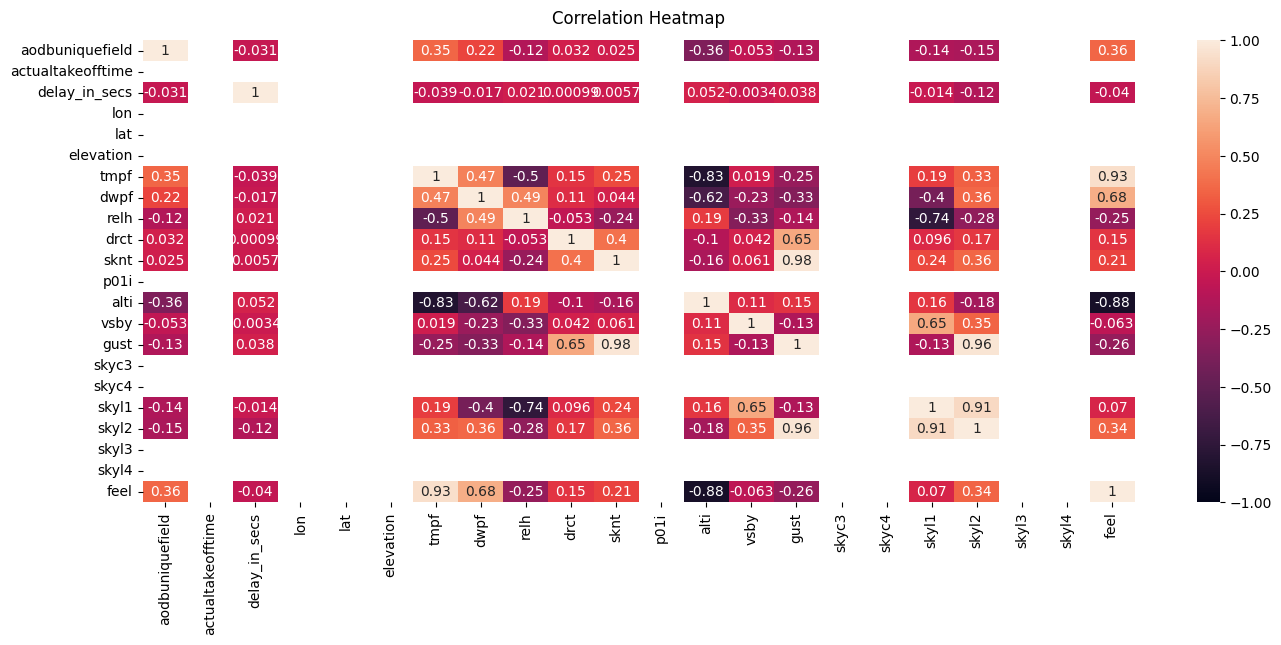

In [28]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(flight_data_train.corr(numeric_only=True), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

tmpf and feel are highly correlated

There are no missing values for feel so we can safetly remove it

In [29]:
columns_to_drop.append('feel')

sknt and gust are correlated

As gust is the sudden increase in speed, it can be explained by wind speed (sknt)

But there are many missing values in gust so we cannot depend on this


In [30]:
pearsonr(flight_data_train['sknt'][flight_data_train['gust'].notna()], flight_data_train['gust'][flight_data_train['gust'].notna()])

PearsonRResult(statistic=0.9763837646342897, pvalue=0.0)

In [31]:
flight_data_train['gust'] = flight_data_train['gust'].notna().astype(int)
flight_data_test['gust'] = flight_data_test['gust'].notna().astype(int)

/tmp/ipykernel_13478/1900097031.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flight_data_train['gust'] = flight_data_train['gust'].notna().astype(int)
/tmp/ipykernel_13478/1900097031.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flight_data_test['gust'] = flight_data_test['gust'].notna().astype(int)


In [32]:
# Drop the duplicate or unnecessary columns
flight_data_train.drop(columns=columns_to_drop, axis=1, inplace=True)
flight_data_test.drop(columns=columns_to_drop, axis=1, inplace=True)

/tmp/ipykernel_13478/2085716974.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flight_data_train.drop(columns=columns_to_drop, axis=1, inplace=True)
/tmp/ipykernel_13478/2085716974.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flight_data_test.drop(columns=columns_to_drop, axis=1, inplace=True)


In [33]:
flight_data_train.dtypes

traffictypecode                  object
airlinecode_iata                 object
destination_iata                 object
via_iata                         object
aircraft_iata                    object
scheduledoffblocktime    datetime64[ns]
publicgatenumber                 object
aircraftterminal                 object
finalflightstatus                object
delay_in_secs                   float64
tmpf                            float64
dwpf                            float64
relh                            float64
drct                            float64
sknt                            float64
p01i                            float64
alti                            float64
vsby                            float64
gust                              int64
skyc1                            object
skyc2                            object
skyc3                           float64
skyc4                           float64
skyl1                           float64
skyl2                           float64


Missing Data

In [34]:
flight_data_train['publicgatenumber'].isnull().sum()

342

In [35]:
flight_data_train['publicgatenumber'].unique()

array(['F8   ', 'D6   ', 'D7   ', 'C14  ', 'A8   ', 'B1   ', 'D11  ',
       'F5   ', 'D13  ', 'D18  ', 'D9   ', 'D3   ', 'D2   ', 'F10  ',
       'D8   ', 'F7   ', 'D21  ', 'D12  ', 'D10  ', 'D15  ', 'F2   ',
       'D14  ', 'F4   ', 'D17  ', 'A14  ', 'F9   ', 'B7   ', 'A10  ',
       'A22  ', 'B19  ', 'F11  ', 'A1   ', 'C43  ', 'B12  ', 'A23  ',
       'C8   ', 'B22  ', 'B14  ', 'B17  ', 'F3   ', 'A15  ', 'C46  ',
       'B23  ', 'A9   ', 'A2   ', 'C5   ', 'C6   ', 'B13  ', 'B25  ',
       'A20  ', 'F6   ', 'B24  ', 'F1   ', 'B2   ', 'B3   ', 'B28  ',
       'A6   ', 'A21  ', 'C7   ', 'C2   ', 'A24  ', 'B10  ', 'A7   ',
       'B11  ', 'C22  ', 'A18  ', 'C13  ', 'B15  ', 'C10  ', 'A4   ',
       'B20  ', 'A19  ', 'D16  ', 'C37  ', 'C19  ', 'C4   ', 'C17  ',
       'C42  ', 'A12  ', 'B4   ', 'B5   ', 'B27  ', 'C11  ', 'C20  ',
       'C18  ', 'A11  ', 'C44  ', 'C21  ', 'B26  ', 'A5   ', 'B8   ',
       'B18  ', 'C40  ', 'C16  ', 'C38  ', 'A17  ', 'C1   ', 'C12  ',
       'A16  ', 'C9 

In [36]:
flight_data_train['aircraftterminal'].isnull().sum()

0

In [37]:
flight_data_train[['publicgatenumber', 'aircraftterminal']][flight_data_train['publicgatenumber'].isnull() == True]

,publicgatenumber,aircraftterminal
946,NaN,1
989,NaN,3
1780,NaN,3
1878,NaN,3
1949,NaN,3
...,...,...
148458,NaN,2
150357,NaN,3
151211,NaN,1
151885,NaN,2


In [38]:
chi_2(flight_data_train, 'publicgatenumber', 'aircraftterminal')
cramers_v(flight_data_train, 'publicgatenumber', 'aircraftterminal')

Chi-Square Statistic for publicgatenumber and aircraftterminal: 356872.12344229314, p-value: 0.0, dof:822
Cramer's V  for publicgatenumber and aircraftterminal: 0.6249331852578075, p-value: 0.0


In [39]:
flight_data_train['publicgatenumber'] = flight_data_train['publicgatenumber'].fillna('UNKNOWN')
flight_data_test['publicgatenumber'] = flight_data_test['publicgatenumber'].fillna('UNKNOWN')

/tmp/ipykernel_13478/3649071926.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flight_data_train['publicgatenumber'] = flight_data_train['publicgatenumber'].fillna('UNKNOWN')
/tmp/ipykernel_13478/3649071926.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flight_data_test['publicgatenumber'] = flight_data_test['publicgatenumber'].fillna('UNKNOWN')


In [40]:
flight_data_train['aircraftterminal'].isnull().sum()

0

In [41]:
flight_data_train.isnull().sum()

traffictypecode               0
airlinecode_iata              0
destination_iata              0
via_iata                 146729
aircraft_iata                 0
scheduledoffblocktime         0
publicgatenumber              0
aircraftterminal              0
finalflightstatus             0
delay_in_secs                 0
tmpf                          0
dwpf                          0
relh                          0
drct                          0
sknt                          0
p01i                          0
alti                          0
vsby                          0
gust                          0
skyc1                    106594
skyc2                    152385
skyc3                    152640
skyc4                    152640
skyl1                    132306
skyl2                    152398
skyl3                    152640
skyl4                    152640
dtype: int64

via_iata

Instead of maintaining the details of connecting flight we can change it indicate if the flight is connection

In [42]:
flight_data_train['isconnecting'] = flight_data_train['via_iata'].notna().map({True: '1', False: '0'})
flight_data_test['isconnecting'] = flight_data_test['via_iata'].notna().map({True: '1', False: '0'})


flight_data_train.drop(columns='via_iata', axis=1, inplace=True)
flight_data_test.drop(columns='via_iata', axis=1, inplace=True)

/tmp/ipykernel_13478/3465108291.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flight_data_train['isconnecting'] = flight_data_train['via_iata'].notna().map({True: '1', False: '0'})
/tmp/ipykernel_13478/3465108291.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flight_data_test['isconnecting'] = flight_data_test['via_iata'].notna().map({True: '1', False: '0'})
/tmp/ipykernel_13478/3465108291.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the ca

/tmp/ipykernel_13478/3465108291.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flight_data_test.drop(columns='via_iata', axis=1, inplace=True)


In [43]:
flight_data_train['isconnecting'].unique()

array(['0', '1'], dtype=object)

In [44]:
print(f'skyc1 unique values:{flight_data_train['skyc1'].unique()}')
print(f'skyc2 unique values:{flight_data_train['skyc2'].unique()}')
print(f'skyc3 unique values:{flight_data_train['skyc3'].unique()}')
print(f'skyc4 unique values:{flight_data_train['skyc4'].unique()}')

print(f'skyl1 unique values:{flight_data_train['skyl1'].unique()}')
print(f'skyl2 unique values:{flight_data_train['skyl2'].unique()}')
print(f'skyl3 unique values:{flight_data_train['skyl3'].unique()}')
print(f'skyl4 unique values:{flight_data_train['skyl4'].unique()}')

skyc1 unique values:[nan 'NSC' 'FEW' 'SCT' 'BKN' 'VV ' 'OVC']
skyc2 unique values:[nan 'NSC' 'BKN' 'SCT' 'FEW']
skyc3 unique values:[nan]
skyc4 unique values:[nan]
skyl1 unique values:[  nan 4500. 4000. 3000. 3500. 3300. 2000. 1200. 1500. 2500.  600. 1300.
  100.  500.  800. 1000.  700. 1400. 1800.  200. 1700. 2400. 2600. 2800.
 2100.  300.  400.  900. 1100. 5000. 3100. 3800. 4300. 3700. 4200. 4400.
 4700. 4600. 4800. 2300. 1600. 3600. 2200. 1900. 2700. 2900. 7000. 4100.
 4900. 3200.]
skyl2 unique values:[  nan 1400. 3500. 4000. 5000. 4500. 3000.]
skyl3 unique values:[nan]
skyl4 unique values:[nan]


We can drop skyc3, skyc4, skyl3 and skyl4 as they are mostly empty

In [45]:
flight_data_train.drop(columns=['skyc3', 'skyc4', 'skyl3', 'skyl4'], axis=1, inplace=True)
flight_data_test.drop(columns=['skyc3', 'skyc4', 'skyl3', 'skyl4'], axis=1, inplace=True)

/tmp/ipykernel_13478/2373328444.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flight_data_train.drop(columns=['skyc3', 'skyc4', 'skyl3', 'skyl4'], axis=1, inplace=True)
/tmp/ipykernel_13478/2373328444.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flight_data_test.drop(columns=['skyc3', 'skyc4', 'skyl3', 'skyl4'], axis=1, inplace=True)


In [46]:
# Replace missing values in 'skyc1' and 'skyc2' with 'NA'
flight_data_train[['skyc1', 'skyc2']] = flight_data_train[['skyc1', 'skyc2']].fillna('CAVOK') # From METAR code
flight_data_test[['skyc1', 'skyc2']] = flight_data_test[['skyc1', 'skyc2']].fillna('CAVOK')

# Replace missing values in 'skyl1' and 'skyl2' with 0
flight_data_train[['skyl1', 'skyl2']] = flight_data_train[['skyl1', 'skyl2']].fillna(0)
flight_data_test[['skyl1', 'skyl2']] = flight_data_test[['skyl1', 'skyl2']].fillna(0)

/tmp/ipykernel_13478/4044442040.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flight_data_train[['skyc1', 'skyc2']] = flight_data_train[['skyc1', 'skyc2']].fillna('CAVOK') # From METAR code
/tmp/ipykernel_13478/4044442040.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flight_data_test[['skyc1', 'skyc2']] = flight_data_test[['skyc1', 'skyc2']].fillna('CAVOK')
/tmp/ipykernel_13478/4044442040.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

In [47]:
flight_data_train.isna().sum()

traffictypecode          0
airlinecode_iata         0
destination_iata         0
aircraft_iata            0
scheduledoffblocktime    0
publicgatenumber         0
aircraftterminal         0
finalflightstatus        0
delay_in_secs            0
tmpf                     0
dwpf                     0
relh                     0
drct                     0
sknt                     0
p01i                     0
alti                     0
vsby                     0
gust                     0
skyc1                    0
skyc2                    0
skyl1                    0
skyl2                    0
isconnecting             0
dtype: int64

In [48]:
flight_data_test.columns

Index(['traffictypecode', 'airlinecode_iata', 'destination_iata',
       'aircraft_iata', 'scheduledoffblocktime', 'publicgatenumber',
       'aircraftterminal', 'finalflightstatus', 'delay_in_secs', 'tmpf',
       'dwpf', 'relh', 'drct', 'sknt', 'p01i', 'alti', 'vsby', 'gust', 'skyc1',
       'skyc2', 'skyl1', 'skyl2', 'isconnecting'],
      dtype='object')

In [49]:
flight_data_train['aircraftterminal'].unique()

array(['2 ', '1 ', '3 ', 'PT', 2, 3, 1], dtype=object)

In [50]:
aircraftterminal_map = {0: 0, 1: 1, 2: 2, 3: 3, "2 ": 2, "1 ": 1, "3 ": 3, "PT": 0}
flight_data_train["aircraftterminal"] = flight_data_train["aircraftterminal"].map(
    aircraftterminal_map
)
flight_data_test["aircraftterminal"] = flight_data_test["aircraftterminal"].map(
    aircraftterminal_map
)

/tmp/ipykernel_13478/1293972564.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flight_data_train["aircraftterminal"] = flight_data_train["aircraftterminal"].map(
/tmp/ipykernel_13478/1293972564.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flight_data_test["aircraftterminal"] = flight_data_test["aircraftterminal"].map(


In [51]:
flight_data_train['aircraftterminal'].unique()

array([2, 1, 3, 0])

In [52]:
print(flight_data_train['p01i'].value_counts())
print(flight_data_test['p01i'].value_counts())

p01i
0.0    152640
Name: count, dtype: int64
p01i
0.0    38161
Name: count, dtype: int64


In [53]:
flight_data_train.drop(columns=['p01i'], axis=1, inplace=True)
flight_data_test.drop(columns=['p01i'], axis=1, inplace=True)

/tmp/ipykernel_13478/2969017280.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flight_data_train.drop(columns=['p01i'], axis=1, inplace=True)
/tmp/ipykernel_13478/2969017280.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flight_data_test.drop(columns=['p01i'], axis=1, inplace=True)


In [54]:
non_numeric_columns = list(set(flight_data_train.columns)-set(flight_data_train._get_numeric_data().columns))
for col in non_numeric_columns:
    flight_data_train[col] = flight_data_train[col].apply(lambda x : str(x).strip())
    flight_data_test[col] = flight_data_test[col].apply(lambda x : str(x).strip())

/tmp/ipykernel_13478/2445916566.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flight_data_train[col] = flight_data_train[col].apply(lambda x : str(x).strip())
/tmp/ipykernel_13478/2445916566.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flight_data_test[col] = flight_data_test[col].apply(lambda x : str(x).strip())
/tmp/ipykernel_13478/2445916566.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

In [55]:
cols = [
    "scheduledoffblocktime",
    # "flightnumber",
    "traffictypecode",
    "airlinecode_iata",
    "destination_iata",
    "aircraft_iata",
    "isconnecting",
    # "aircraftparkingposition",
    "publicgatenumber",
    "aircraftterminal",
    "tmpf",
    "dwpf",
    "relh",
    "drct",
    "sknt",
    # "p01i",
    "alti",
    "vsby",
    "gust",
    "skyc1",
    "skyc2",
    "skyl1",
    "skyl2",
    "finalflightstatus",
    "delay_in_secs",
]

In [56]:
flight_data_train.isnull().sum()

traffictypecode          0
airlinecode_iata         0
destination_iata         0
aircraft_iata            0
scheduledoffblocktime    0
publicgatenumber         0
aircraftterminal         0
finalflightstatus        0
delay_in_secs            0
tmpf                     0
dwpf                     0
relh                     0
drct                     0
sknt                     0
alti                     0
vsby                     0
gust                     0
skyc1                    0
skyc2                    0
skyl1                    0
skyl2                    0
isconnecting             0
dtype: int64

In [57]:
flight_data_train[cols].to_csv('./flight_data_train_ts.csv', index=False)
flight_data_test[cols].to_csv('./flight_data_test_ts.csv', index=False)

# flight_data_train = flight_data_train[cols].reset_index(drop=True)
# flight_data_test = flight_data_test[cols].reset_index(drop=True)